# Welcome to the LSBoosting Notebook for Folktables!

In this notebook, you'll be able to import US Census data from Folktables easily via the helper function and then train a LSBoostRegressor using your choice of hyperparameters!

### Install/Imports

In [15]:
import LSBoost
# from LSBoost import LSBoostingRegressor
import helper_functions as hf

import pandas as pd

import numpy as np

import sklearn as sk
from sklearn.model_selection import train_test_split
from helper_functions import MSCE as MSCE
from sklearn.metrics import mean_squared_error as MSE

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor

import gc
import time
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

### Data Control Panel

Training data size: 437816
Test data size: 109455
Max y value: 1.0
Min y value: 0.0
Mean train label: 0.37863976060090154
Mean test label: 0.3793950676955826
Std train label: 0.26135886666234426
Std test label: 0.26238206917782525


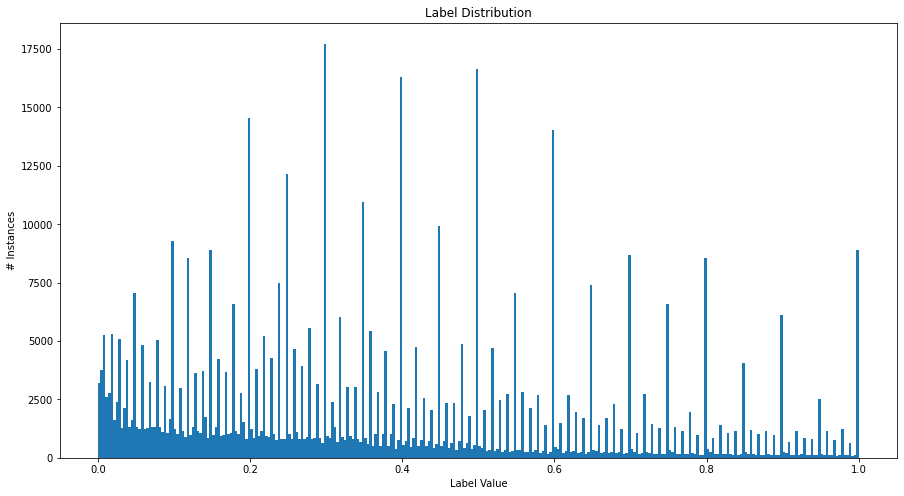

In [2]:
#set random seed
random_state = 42
np.random.seed(random_state)

# set dataset task
dataset_task = 'ACSIncome'
target = 0
states_list = ['CA', 'PA', 'NY', 'TX', 'FL', 'MD']
year = '2018'

# max income value
cutoff = 100_000

# import data
data, labels = hf.get_data(task = dataset_task, target = target, states_list = states_list, year = year, cutoff = cutoff, random_state = random_state+1)

# split train test data
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size = .2, random_state = random_state)

# print out label information
hf.print_data_report(x_train, x_test, y_train, y_test)

### Hyperparameter Tuning

In [114]:
# number of rounds - (integer)
T = 100

# level sets - (integer)
num_bins = 100

# minimum number of points in level set for update to occur - (integer)
min_group_size = 5

# amount (multiplicative) level set must improve by to accept update if validation data or leniency factor for update requirements - (float)
global_gamma = .005

# weak learner class for UDT - (ML class with .predict method)
weak_learner = DecisionTreeRegressor(max_depth = 1)

# determines width of level sets, either 'default' for equal width or 'distribution' for equal number of expected points - (string)
bin_type = 'distribution'

# multiplicative weight for new update - (float)
learning_rate = 1

# starting model to boost. Set to None for weak learner to be use as initial model - (fit ML class with .predict method or None)
initial_model = None

# round final predictions to level set center or use output of weak learner - (bool)
final_round = True

# center level sets using historical mean - (bool)
center_mean = True

### Train LSBoost Regressor

In [115]:
LSBoostReg = LSBoost.LSBoostingRegressor(
                                T = T, 
                                num_bins = num_bins, 
                                min_group_size = min_group_size, 
                                global_gamma = global_gamma, 
                                weak_learner= weak_learner, 
                                bin_type = bin_type, 
                                learning_rate = learning_rate, 
                                initial_model = initial_model,  
                                final_round = final_round, 
                                center_mean=center_mean)
LSBoostReg.fit(x_train, y_train)

LS:   0%|           0/100 ?, Training Error=0.0551354

Early Termination at round: 37
Memory released!


### Predict on train/test data and print MSE/MSCE on train/test

In [116]:
print(f'Number of weak learner updates made: {LSBoostReg.updates} \n')

training_predictions = LSBoostReg.predict(x_train)
test_predictions = LSBoostReg.predict(x_test)

print(f'Train Error: {MSE(y_train, training_predictions):.6f}')
print(f'Test Error: {MSE(y_test, test_predictions):.6f}\n')

print(f'Calibration Error: {MSCE(y_train, training_predictions):.6f}')
print(f'Calibration Error: {MSCE(y_test, test_predictions):.6f}')

Number of weak learner updates made: 2386 

Train Error: 0.032806
Test Error: 0.034591

Calibration Error: 0.000000
Calibration Error: 0.000078


### Track MSE/MSCE for each round on train/test data

In [117]:
training_errors_mse = LSBoostReg.track(x_train, y_train, MSE)
test_errors_mse = LSBoostReg.track(x_test, y_test, MSE)
training_errors_msce = LSBoostReg.track(x_train, y_train, MSCE)
test_errors_msce = LSBoostReg.track(x_test, y_test, MSCE)

### Graph errors

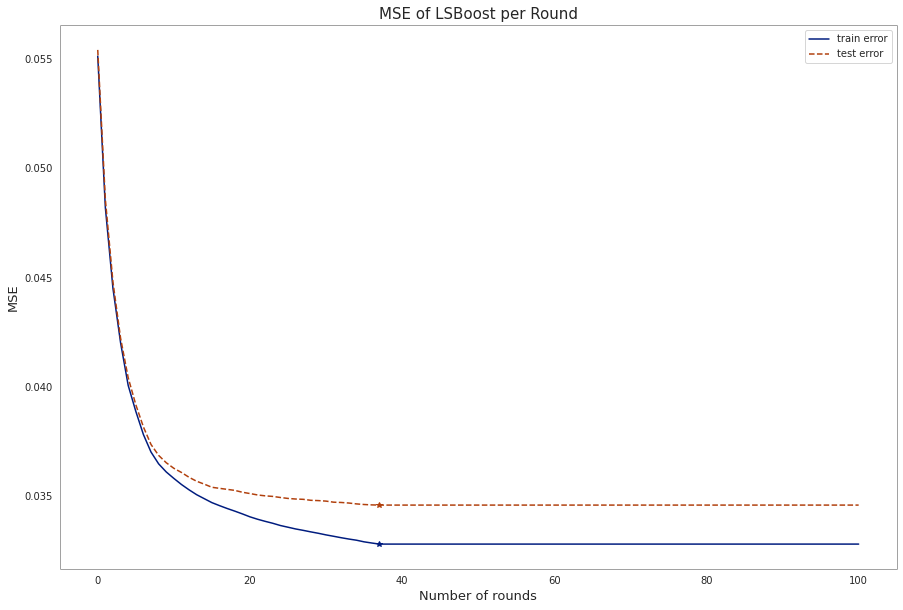

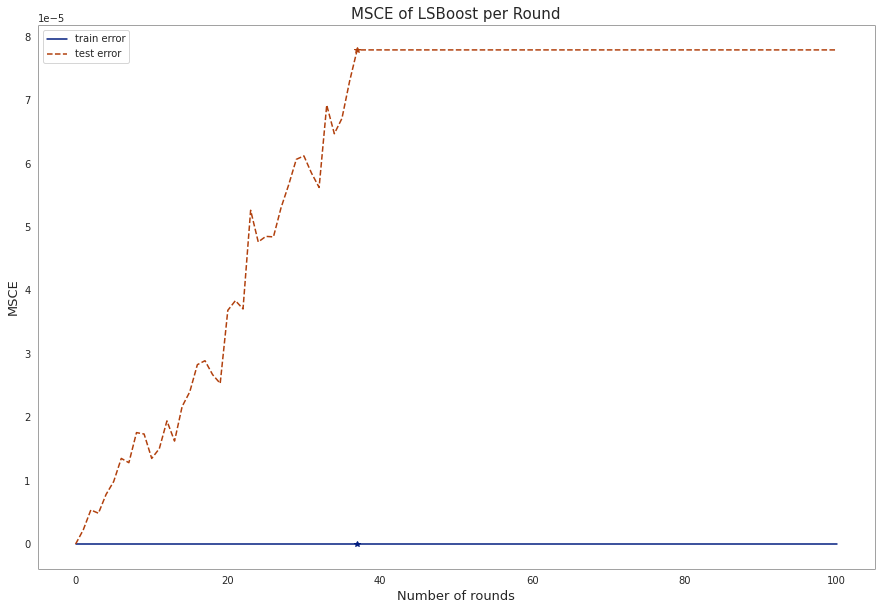

In [118]:
hf.test_train_graph({'train error': training_errors_mse, 'test error':test_errors_mse, }, title='MSE of LSBoost per Round', ref_line = LSBoostReg.round_count, dotted = 'test', y_axis = 'MSE')
hf.test_train_graph({'train error': training_errors_msce, 'test error':test_errors_msce, }, title='MSCE of LSBoost per Round', ref_line = LSBoostReg.round_count, dotted = 'test', y_axis = 'MSCE')

### Train LSBoost Regressor with validation hueristic

In [119]:
x_train_no_val, x_val, y_train_no_val, y_val = train_test_split(x_train, y_train, test_size = .2, random_state=42)

LSBoostRegValidation = LSBoost.LSBoostingRegressor(
                                T = T, 
                                num_bins = num_bins, 
                                min_group_size = min_group_size, 
                                global_gamma = global_gamma, 
                                weak_learner= weak_learner, 
                                bin_type = bin_type, 
                                learning_rate = learning_rate, 
                                initial_model = initial_model,  
                                final_round = final_round, 
                                center_mean=center_mean)
LSBoostRegValidation.fit_validation(x_train_no_val, y_train_no_val, x_val, y_val)

LS:   0%|           0/100 ?, Lowest Val Error=0.0554928, Training Error=0.0550461, Val Error=0.0554928

Early Termination at round: 14
Memory released!


In [120]:
print(f'Number of weak learner updates made: {LSBoostRegValidation.updates} \n')

training_predictions = LSBoostRegValidation.predict(x_train)
test_predictions = LSBoostRegValidation.predict(x_test)

print(f'Train Error: {MSE(y_train, training_predictions):.6f}')
print(f'Test Error: {MSE(y_test, test_predictions):.6f}\n')

print(f'Calibration Error: {MSCE(y_train, training_predictions):.6f}')
print(f'Calibration Error: {MSCE(y_test, test_predictions):.6f}')

Number of weak learner updates made: 275 

Train Error: 0.035715
Test Error: 0.036173

Calibration Error: 0.000000
Calibration Error: 0.000022


In [121]:
training_errors_mse = LSBoostRegValidation.track(x_train, y_train, MSE)
test_errors_mse = LSBoostRegValidation.track(x_test, y_test, MSE)
training_errors_msce = LSBoostRegValidation.track(x_train, y_train, MSCE)
test_errors_msce = LSBoostRegValidation.track(x_test, y_test, MSCE)

In [ ]:
hf.test_train_graph({'train error': training_errors_mse, 'test error':test_errors_mse, }, title='MSE of LSBoost per Round', ref_line = LSBoostReg.round_count, dotted = 'test', y_axis = 'MSE')
hf.test_train_graph({'train error': training_errors_msce, 'test error':test_errors_msce, }, title='MSCE of LSBoost per Round', ref_line = LSBoostReg.round_count, dotted = 'test', y_axis = 'MSCE')